<a href="https://colab.research.google.com/github/OSGeoLabBp/tutorials/blob/master/english/machine_learning/lessons/keras_time.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time series estimation with Deep Learning

## Prepearing data

We use death data in Hungary from 2015 to 2024. Data were downloaded from the Central Statistics Office of Hungary.

Let's have the data as a pandas data frame.

In [101]:
import pandas as pd
import matplotlib.pyplot as plt

In [102]:
# adatok betöltése
!wget -q https://raw.githubusercontent.com/OSGeoLabBp/tutorials/master/english/machine_learning/lessons/data/weekly_death.csv
df = pd.read_csv('weekly_death.csv', parse_dates=['start', 'end'])

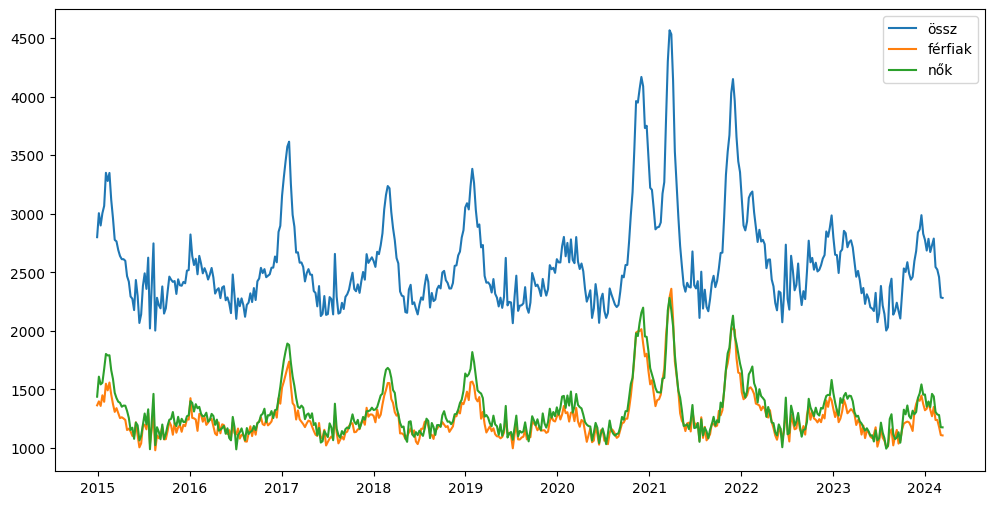

In [103]:
plt.figure(figsize=(12,6))
plt.plot(df['start'], df['all_total'], label='össz')
plt.plot(df['start'], df['man_total'], label='férfiak')
plt.plot(df['start'], df['woman_total'], label='nők')
plt.legend()

## Using Keras and 1D convolutional neural network

In [136]:
from numpy import zeros
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Conv1D
from keras.layers import MaxPooling1D

In [139]:
# split a univariate sequence into samples
def split_sequence(seq, n_steps):
	sequence = seq.to_numpy()
	n = sequence.shape[0]
	X = zeros((n - n_steps, n_steps))
	y = sequence[n_steps:]
	for i in range(n-n_steps):
		X[i] = sequence[i:i+n_steps]
	return X, y

In [140]:
# define input sequence
raw = df.loc[df['start'] < '2024-01-01']
raw_seq = raw['all_total']
# choose a number of time steps
n_steps = 3
# split into samples
X, y = split_sequence(raw_seq, n_steps)

In [162]:
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))
# define model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps, n_features)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse', metrics=["accuracy"])
# fit model
hist = model.fit(X, y, epochs=1000, verbose=0)
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_9 (Conv1D)           (None, 2, 64)             192       
                                                                 
 max_pooling1d_9 (MaxPoolin  (None, 1, 64)             0         
 g1D)                                                            
                                                                 
 flatten_9 (Flatten)         (None, 64)                0         
                                                                 
 dense_18 (Dense)            (None, 50)                3250      
                                                                 
 dense_19 (Dense)            (None, 1)                 51        
                                                                 
Total params: 3493 (13.64 KB)
Trainable params: 3493 (13.64 KB)
Non-trainable params: 0 (0.00 Byte)
____________________

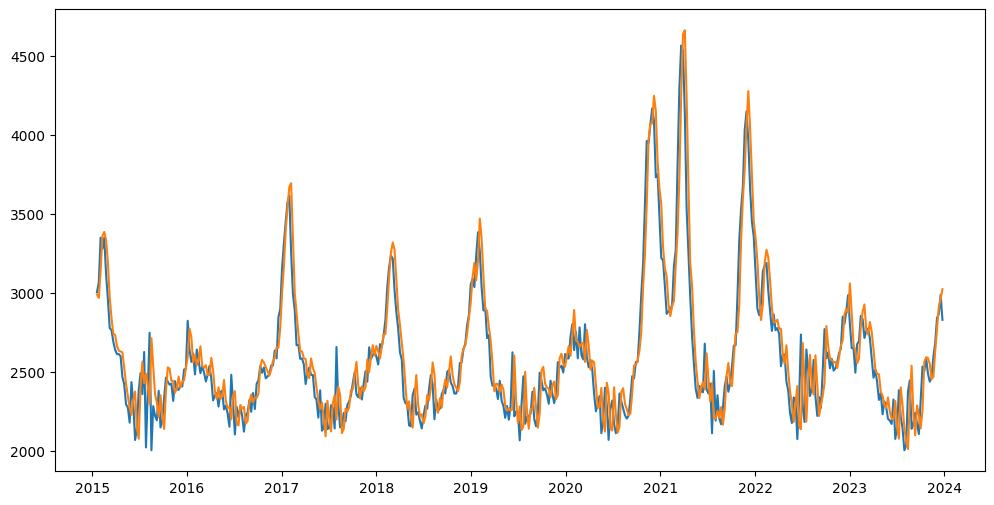

In [144]:
# predict values from model
y_pred = model.predict(X, verbose=0)
plt.figure(figsize=(12,6))
plt.plot(raw["start"][n_steps:], y)
plt.plot(raw["start"][n_steps:], y_pred)

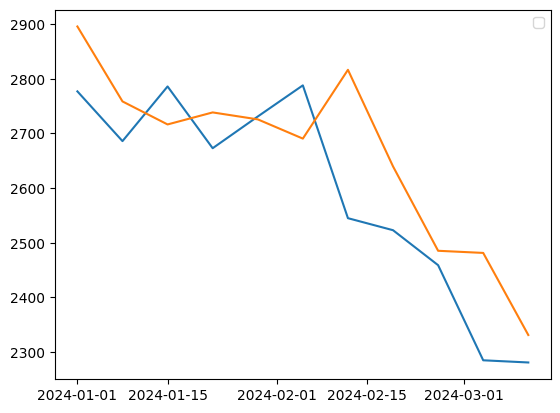

In [163]:
# make estimation for 2024 data
test = df.loc[df['start'] >= '2023-12-11']
test_seq = test['all_total']
X_test, y_test = split_sequence(test_seq, n_steps)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))
y_test_pred = model.predict(X_test, verbose=0)
plt.plot(test['start'][-y_test.shape[0]:], y_test, label='ground truth')
plt.plot(test['start'][-y_test.shape[0]:], y_test_pred, label='estimated')
plt.legend()

## Using XGBoost

In [36]:
import xgboost as xgb

In [66]:
# feature creation
df['quarter'] = df['start'].dt.quarter
df['month'] = df['start'].dt.month
FEATURES = ['year', 'quarter', 'month', 'week']
TARGET = 'all_total'

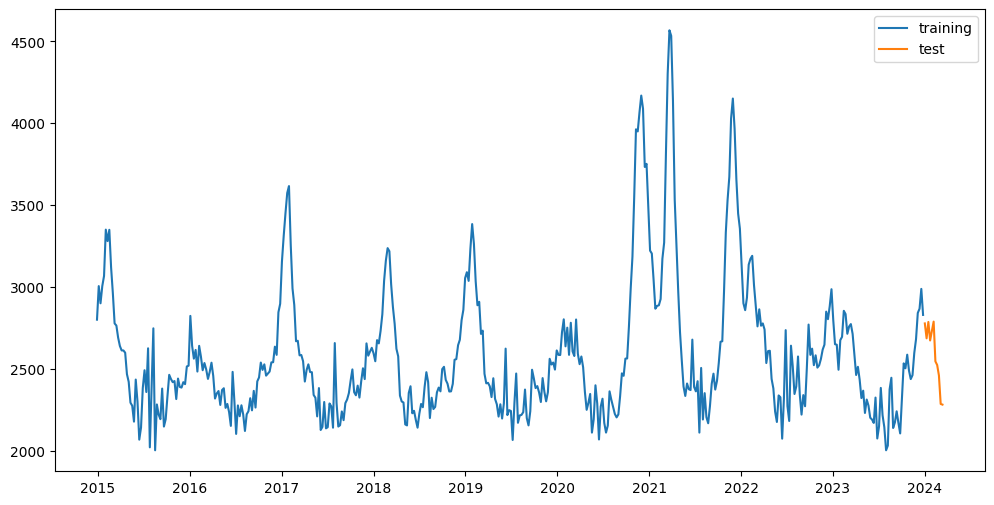

In [68]:
# split data into train and test set
train = df.loc[df['start'] < '2024-01-01']
test = df.loc[df['start'] >= '2024-01-01']
plt.figure(figsize=(12,6))
plt.plot(train['start'], train['all_total'], label='training')
plt.plot(test['start'], test['all_total'], label='test')
plt.legend()

In [69]:
train.columns

Index(['year', 'week', 'start', 'end', 'man_0_34', 'man_35_39', 'man_40_44',
       'man_45_49', 'man_50_54', 'man_55_59', 'man_60_64', 'man_65_69',
       'man_70_74', 'man_75_79', 'man_80_84', 'man_85_89', 'man_90_',
       'man_total', 'woman_0_34', 'woman_35_39', 'woman_40_44', 'woman_45_49',
       'woman_50_54', 'woman_55_59', 'woman_60_64', 'woman_65_69',
       'woman_70_74', 'woman_75_79', 'woman_80_84', 'woman_85_89', 'woman_90_',
       'woman_total', 'all_0_34', 'all_35_39', 'all_40_44', 'all_45_49',
       'all_50_54', 'all_55-59', 'all_60_64', 'all_65_69', 'all_70_74',
       'all_75_79', 'all_80_84', 'all_85_89', 'all_90_', 'all_total',
       'quarter', 'month'],
      dtype='object')

In [73]:
# create model and fit
X_train = train[FEATURES]
y_train = train[TARGET]
X_test = test[FEATURES]
y_test = test[TARGET]
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective= 'reg:squarederror', #'reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[0]	validation_0-rmse:2590.24931	validation_1-rmse:2571.18004
[100]	validation_0-rmse:993.35495	validation_1-rmse:797.68674
[200]	validation_0-rmse:430.13913	validation_1-rmse:271.61477
[300]	validation_0-rmse:252.11696	validation_1-rmse:188.28293
[325]	validation_0-rmse:233.67981	validation_1-rmse:192.28583


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

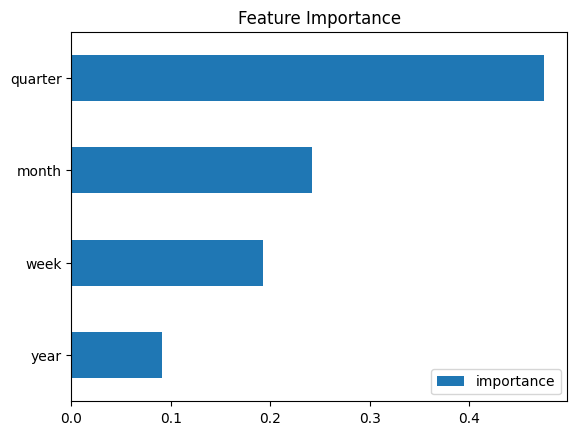

In [74]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

470    2563.587646
471    2563.587646
472    2563.587646
473    2563.587646
474    2563.587646
475    2563.587646
476    2563.587646
477    2563.587646
478    2563.587646
479    2569.577637
480    2569.577637
Name: prediction, dtype: float32

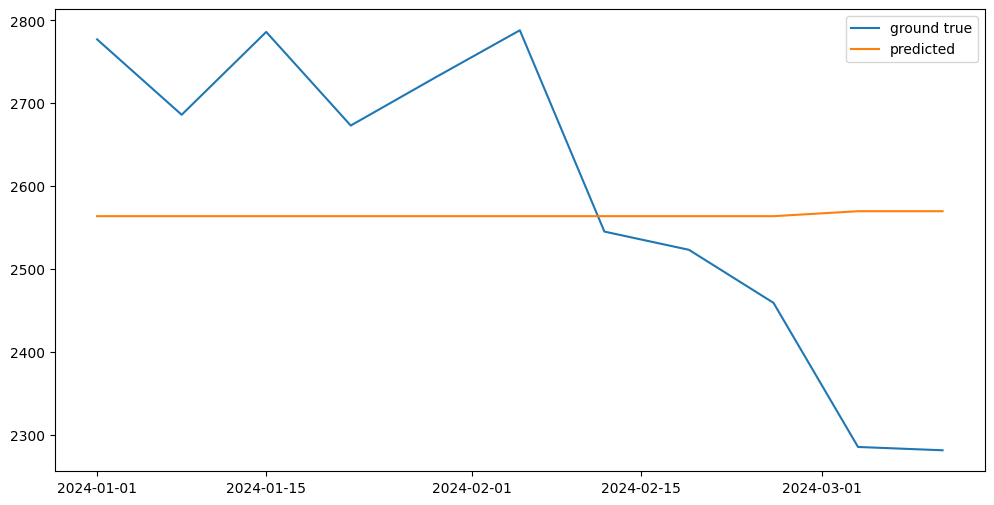

In [79]:
test['prediction'] = reg.predict(X_test)
plt.figure(figsize=(12,6))
plt.plot(test['start'], test['all_total'], label='ground true')
plt.plot(test['start'], test['prediction'], label='predicted')
plt.legend()
test['prediction']